# TCLAB Test PID en boucle fermée

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from scipy.optimize import minimize
from matplotlib import colors as mcolors
from math import exp

import package_LAB
from package_LAB import LeadLag_RT, PID_RT, Margin, IMC_Tuning
import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

from importlib import reload
package_LAB = reload(package_LAB)

import tclab
import time
from datetime import datetime
import os

## Scenario

In [3]:
Scenario = "TCLAB_Simu"

if(Scenario == "TCLAB_Simu"):
    TSim = 2500

    SPPath = {0:75, 1300:65, 1500:65, TSim:65}
    MVManPath = {0:50, TSim:50}
    ManPath = {0:True, 500:False, TSim:False}
    DVPath = {0:50, 2000:60, TSim:60}
    ManFF = False
    
    NumRTsteps = TSim

## Calcul de DV0 & PV0

In [4]:
nameFile1 = 'Open_loop_experiment_on_MV_2024-03-18-09h26.txt'

titleName1 = nameFile1.split('.')[0]
data1 = pd.read_csv(nameFile1)
t1 = data1['t'].values - data1['t'].values[0]

PV0 = 0
for i in range(len(t1)):
    PV0 += data1['PV'].values[i]
PV0 = PV0/len(t1)
print(PV0)


70.1002900552487


## Simulation Closed loop Parameters

In [5]:
Ts = 1
N = int(TSim/Ts) + 1

MV0 = 50
DV0 = 50
PV0 = 70

t = []
MV = []
MVSave = [MV0]
E = []
SP = []
PV = []
PV1p = []
PV2p = []
PV1d = []
PV2d = []
DV = []
Man = []
MVMan = []
MVFF = []
MVFF_Delay = []
MV_Delayp = []
MV_Delayd = []
MVP = []
MVI = []
MVD = []


# Parameters
Kp = 0.4971
Kd = 0.3734
Kff = Kd/Kp #0.7512

alpha = 0.9
theta_p = 4.386
theta_d = 12.181
theta_ff = max(0, theta_d-theta_p)

MVMin = 0
MVMax = 100

T1d = 153.9969
T2d = 42.4662

T1p = 201.8353
T2p = 14.1389

MVFFdv = []
MVFFpv = []

T1 = T1p
T2 = T2p
gamma = 0.6

## Test Closed loop


TypeError: object of type 'int' has no len()

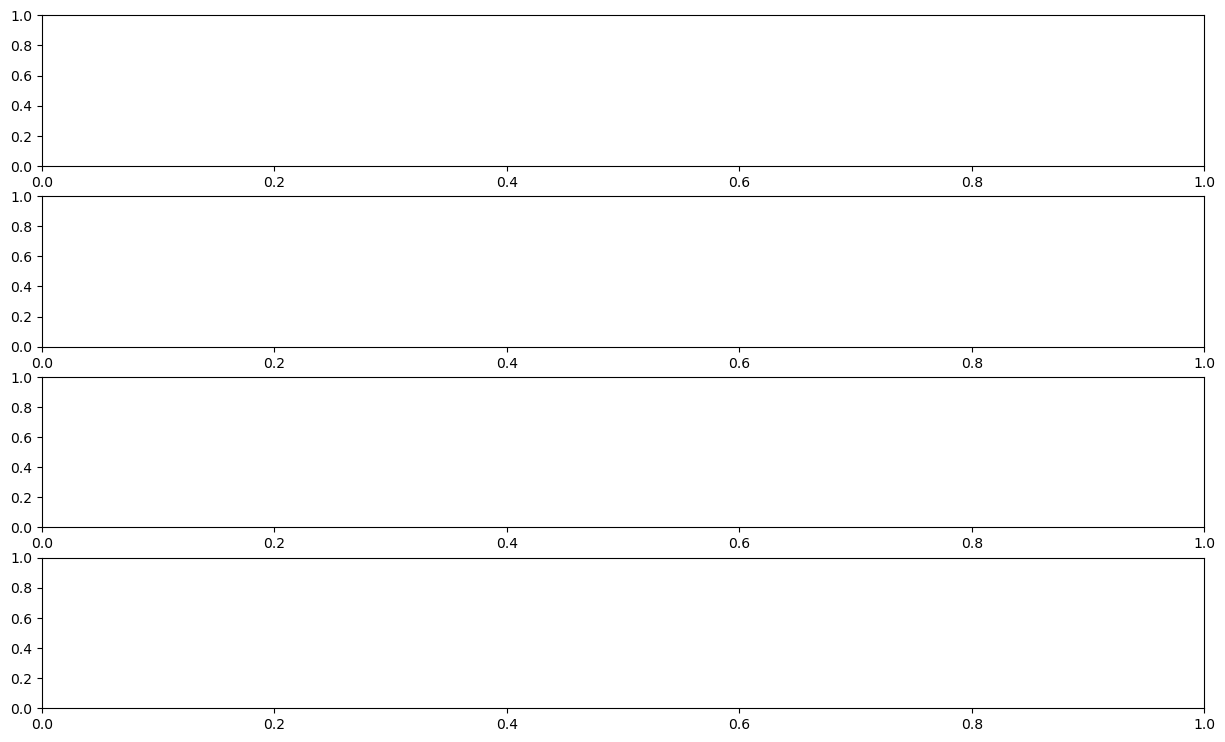

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)

fig.set_figheight(9)
fig.set_figwidth(15)

l1, = ax1.step([0, len(TSim)],[0, len(TSim)],'black',label='Man',where='pre')
ax1.set_ylabel('Value of Man [%]')
ax1.set_title('PID CLP FF test')
ax1.set_xlim([0, TSim])
ax1.set_ylim([-0.1,1.1])

l2, = ax2.step([0,TSim],[0,TSim],'r-',label='MV',where='pre')
l3, = ax2.step([0,TSim],[0,TSim],'green',label='MVP',where='pre', ls = '--', linewidth = '1' )
l4, = ax2.step([0,TSim],[0,TSim],'blue',label='MVI',where='pre', ls = '--', linewidth = '1')
l5, = ax2.step([0,TSim],[0,TSim],'cyan',label='MVD',where='pre', ls = '--', linewidth = '1')
l6, = ax2.step([0,TSim],[0,TSim],'black',label='MVFF',where='pre', ls = '--', linewidth = '1')
ax2.set_ylabel('Values of MV')
ax2.legend(loc="upper right", bbox_to_anchor=(1,1))
ax2.set_xlim([0, TSim])
ax2.set_ylim([-60,115])

l7, = ax3.step([0,TSim],[0,TSim],'-g', label='PV',where='post')
l8, = ax3.step([0,TSim],[0,TSim],'-r', label='SP',where='post')
ax3.set_ylabel('Value of PV and SP')
ax3.legend(loc="upper right", bbox_to_anchor=(1,1))
ax3.set_xlim([0, TSim])

l9, = ax4.step([0,TSim],[0,TSim],'-r', label='DV',where='post')
ax4.set_ylabel('Value of DV')
ax4.set_xlabel('Time [s]')
ax4.legend(loc='best')
ax4.set_xlim([0, TSim]) 


lab = tclab.TCLab()

Exp = True


i = 0
[Kc, Ti, Td] = IMC_Tuning(T1, T2, T1p, gamma, Kp)

while Exp:
    
    if (len(t) == 0):
        MVValue = MV0
        DVValue = DV0
        
    lab.Q1(MVValue)
    lab.Q2(DVValue)
    
    t.append(i*Ts)
    
    if t[-1] == 0:
        last_time = time.time()    
    
    MV.append(MVValue)
    DV.append(DVValue)    
    PV.append(lab.T1)
    
    # Wait for sampling period Ts
    now = time.time()
    delta = now - last_time
    
    time.sleep(np.max([0, Ts - delta]))
    last_time = time.time()    
    
    l1.set_data(t,Man)
    l2.set_data(t,MV)
    l3.set_data(t,MVP)
    l4.set_data(t,MVI)
    l5.set_data(t,MVD)
    l6.set_data(t,MVFF)
    l7.set_data(t,PV)
    l8.set_data(t,SP)
    l9.set_data(t,DV)
    
    
    clear_output(wait=True)    
    
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(MVManPath,t,MVMan)
    SelectPath_RT(ManPath,t,Man)
    
    
    #MVFF
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([theta_d-theta_p,0]),Ts,MVFF_Delay, DV0)
    
    LeadLag_RT(MVFF_Delay, -Kff, T1p, T1d, Ts, MVFFdv)
    LeadLag_RT(MVFFdv, 1, T2p, T2d, Ts, MVFF)

    
    PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVMin, MVMax, MVSave, MVP, MVI, MVD, E, ManFF)
    
    MVValue = MVSave[-1]
    
    display(fig)     
    
    i = i + 1
    
    if i == NumRTsteps:
        Exp = False
        lab.close()

        
        
# Save data in text file
# ----------------------
now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")
# Conversion to array
t = np.array(t) 
MV = np.array(MV)
PV = np.array(PV)
DV = np.array(DV)        
my_data = np.vstack((t.T,MV.T,PV.T,DV.T))
my_data = my_data.T
nameFile = 'Data/RT_test_on_' + date_time + '.txt'
if not os.path.exists('Data'):
    os.makedirs('Data')
np.savetxt(nameFile,my_data,delimiter=',',header='t,MV,PV,DV',comments='')        


# Save Plot
# ---------
if not os.path.exists('Plots'):
    os.makedirs('Plots')

titleName = 'RT_test_on_' + date_time
plt.savefig('Plots\\' + titleName + '.png',transparent=True)
plt.savefig('Plots\\' + titleName + '.pdf',transparent=True)
    
    
    
